<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual_notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 1
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [279]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [280]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [281]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [282]:
from functools import partial
from torch.nn import init
from typing import Iterable
torch.Tensor.ndim = property(lambda x: len(x.shape))

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class ListContainer():
  def __init__(self, items): self.items = listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
    if len(self)>10: res = res[:-1] + "...]"
    return res

def children(m): return list(m.children())

def append_stats_non_normal(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds .append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

def append_stats_normal(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def __del__(self): self.remove()
  def remove(self): self.hook.remove()
    
class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms.children()])
  def __enter__(self, *args): return self
  def __exit__ (self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def init_cnn_(m, f):
    if isinstance(m, nn.ConvTranspose2d):
      f(m.weight, a=0.1)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    if isinstance(m, nn.Linear):
      f(m.weight, a=0.)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [283]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [284]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [285]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [286]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [287]:
model_name = model.__name__
z_dim = 1000
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [2.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [288]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)

#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [289]:
# old Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

    self.half = max(self.gf_dim // 2, 1) 
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

    self.quarter = max(self.gf_dim // 4, 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

    self.eighth = max(self.gf_dim // 8, 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = max(self.gf_dim // 16, 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
#     p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
#     p_out = self.forward_z(p)
#     n_out = self.forward_z(n)
    
#     return z_out, p_out, n_out, inputs
    return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [290]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
#     print("ap_dist: {}, an_dist: {}".format(ap_dist, an_dist))
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [291]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

fool_loss_count = 0

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result

# def fool_loss_incorrect(input, target):
#   true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
#   target_probabilities = input.gather(1, true_class)
#   epsilon = 1e-10
#   result =  -1 * torch.log(torch.mean(1 - target_probabilities) + epsilon)
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 40 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
#   return result

# def fool_loss_old(input, target, trash):
#   print("fool_loss:")
#   true_class = torch.argmax(target, dim=1).view(-1,1).long()
#   print(true_class)
#   print("input: ", input.shape)
#   a = input.gather(1, true_class)
#   print(a)
#   print(1 - a)
#   print(torch.mean(1 - a))
#   print(torch.log(torch.mean(1-a)))
#   print("\n\n")
#   # this is wrong! first log should be taken, THEN mean.
#   return -1 * torch.log(torch.mean(1 - input.gather(1, true_class)))


# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [292]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [293]:
# old FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
        self.triplet_weight = 10.
        self.triplet_weight_noise = 5.
        self.triplet_weight_sm = 5.
        
#         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    def forward(self, inp, target):
      sigma_B, _, _, X_B = inp

      X_A = X_B + sigma_B
      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      fooling_loss =  fool_loss(A_Y, B_Y)

      raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
      weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

      self.losses = [fooling_loss] + weighted_diversity_losses
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      return sum(self.losses)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [294]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [295]:
env.save_filename = 'resnet50_24'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [296]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])

# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [297]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50_14/resnet50_14_49'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

# learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

In [298]:
# list(gen.children())

In [299]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: resnet50 
	load filename: None 
	save filename: resnet50_24

please MAKE SURE that the config is correct.


In [300]:
# w = 2
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
learn.fit(40, lr=1e-02, wd = 0., callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(2):
#   learn.fit_one_cycle(7, max_lr=1., div_factor = 80.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

epoch,train_loss,valid_loss,validation,fool_loss,div_loss_0,time
0,3.363520,3.378347,0.466000,1.378392,0.999977,03:34
1,3.230224,3.295447,0.487000,1.295517,0.999965,03:33
2,2.699166,2.698510,0.559000,1.032403,0.833054,03:34
3,2.211566,2.296930,0.647000,0.861328,0.717801,03:34
4,2.231647,2.186102,0.660000,0.832961,0.676570,03:34
5,2.053151,2.192463,0.662000,0.794732,0.698866,03:33
6,2.034477,2.149428,0.679000,0.742267,0.703580,03:38
7,1.988328,2.123027,0.683000,0.737066,0.692981,03:34
8,1.955653,2.049188,0.680000,0.730698,0.659245,03:32
9,1.881450,2.021614,0.703000,0.680907,0.670353,03:34


target probs tensor([[4.4304e-01],
        [9.9081e-01],
        [6.6640e-01],
        [2.2571e-01],
        [6.4908e-04],
        [4.1743e-02],
        [8.9604e-01],
        [9.9998e-01],
        [4.2516e-03],
        [9.9954e-01],
        [1.0562e-01],
        [7.6032e-01],
        [2.0050e-03],
        [1.9001e-04],
        [2.0727e-01],
        [7.9874e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.9424424171447754: 
target probs tensor([[0.2991],
        [0.0449],
        [0.2436],
        [0.9965],
        [0.8888],
        [0.9990],
        [0.6573],
        [0.9953],
        [0.9987],
        [0.7799],
        [0.8489],
        [0.6269],
        [0.0353],
        [0.4835],
        [0.0134],
        [0.0739]], device='cuda:0', grad_fn=<GatherBackward>), loss: 2.1028363704681396: 
target probs tensor([[3.8777e-05],
        [9.6239e-01],
        [1.2129e-02],
        [1.4902e-02],
        [8.7115e-01],
        [3.0553e-01],
        [9.8870e-01],
        [1.0762e-02],
 

target probs tensor([[0.0201],
        [0.9698],
        [0.4262],
        [0.6482],
        [0.0962],
        [0.9961],
        [0.0195],
        [0.0622],
        [0.3245],
        [0.0499],
        [0.2706],
        [0.0387],
        [0.5640],
        [0.1046],
        [0.9988],
        [0.4934]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.2483179569244385: 
target probs tensor([[4.6583e-01],
        [3.1094e-01],
        [8.2816e-02],
        [8.2516e-03],
        [2.6159e-04],
        [2.1391e-02],
        [2.2857e-02],
        [7.4749e-02],
        [2.3656e-03],
        [4.9206e-01],
        [9.3541e-03],
        [2.0035e-04],
        [4.6098e-03],
        [9.6274e-01],
        [9.9993e-01],
        [8.7690e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.0511118173599243: 
target probs tensor([[0.0348],
        [0.5757],
        [0.5230],
        [0.9930],
        [0.1151],
        [0.9998],
        [0.0914],
        [0.0321],
        [0.9187],
        [0.9880

target probs tensor([[2.4155e-01],
        [3.0793e-01],
        [8.7850e-01],
        [7.6631e-02],
        [2.3302e-02],
        [7.9272e-01],
        [8.6815e-01],
        [1.0572e-01],
        [7.7832e-02],
        [9.7612e-01],
        [4.7469e-01],
        [9.0884e-06],
        [5.7045e-01],
        [1.2230e-01],
        [4.8573e-02],
        [1.2750e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.7540513277053833: 
target probs tensor([[7.2067e-02],
        [1.1058e-03],
        [2.7709e-02],
        [6.9359e-06],
        [7.6954e-04],
        [2.7559e-01],
        [7.1623e-03],
        [6.6505e-01],
        [9.9569e-01],
        [2.1651e-02],
        [9.9968e-01],
        [9.9958e-01],
        [1.8902e-01],
        [1.3569e-02],
        [5.7234e-01],
        [6.9247e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.5667403936386108: 
target probs tensor([[5.1653e-01],
        [9.9839e-01],
        [3.1806e-01],
        [9.3061e-01],
        [4.6494e-02],
   

target probs tensor([[9.1641e-01],
        [1.2770e-01],
        [1.2171e-05],
        [1.2056e-06],
        [1.7916e-06],
        [3.2880e-02],
        [4.9156e-02],
        [5.5007e-01],
        [9.3480e-01],
        [2.6048e-01],
        [6.2190e-01],
        [3.9406e-04],
        [3.2298e-02],
        [1.3888e-04],
        [6.5949e-01],
        [6.9605e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6129493713378906: 
target probs tensor([[3.9743e-01],
        [9.6504e-01],
        [1.3461e-02],
        [1.3001e-04],
        [1.4284e-04],
        [9.4802e-04],
        [9.9582e-01],
        [1.6790e-01],
        [1.2272e-02],
        [3.8364e-05],
        [1.1504e-01],
        [1.2859e-02],
        [7.6634e-02],
        [4.9274e-01],
        [5.6233e-03],
        [9.4961e-02]], device='cuda:0'), loss: 0.6592292189598083: 
target probs tensor([[0.8077],
        [0.0018],
        [0.8328],
        [0.9922],
        [0.0879],
        [0.9407],
        [0.0514],
        [0.03

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoch 4 with validation value: 0.6600000262260437.
target probs tensor([[1.2742e-03],
        [2.5970e-04],
        [4.5126e-03],
        [5.3301e-02],
        [2.5004e-06],
        [4.0841e-02],
        [4.3870e-03],
        [8.2972e-01],
        [6.6504e-03],
        [1.5556e-02],
        [5.9965e-03],
        [6.1696e-03],
        [3.6408e-02],
        [7.6396e-01],
        [9.7903e-04],
        [7.5332e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.21214652061462402: 
target probs tensor([[4.5005e-04],
        [5.6608e-06],
        [8.4998e-01],
        [3.8293e-01],
        [2.8470e-02],
        [6.6044e-01],
        [3.5881e-02],
        [2.7443e-02],
        [3.5573e-05],
        [2.7072e-05],
        [5.2829e-05],
        [1.3469e-06],
        [4.8050e-02],
        [7.2025e-02],
        [1.1890e

target probs tensor([[6.1064e-01],
        [7.3758e-01],
        [6.2562e-01],
        [8.8240e-02],
        [2.1445e-03],
        [3.5131e-02],
        [1.5248e-03],
        [2.4972e-02],
        [5.2140e-06],
        [9.8088e-01],
        [1.0613e-02],
        [1.6295e-01],
        [5.6730e-01],
        [9.5053e-03],
        [7.2685e-02],
        [1.0410e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5312223434448242: 
target probs tensor([[6.0775e-03],
        [1.3636e-01],
        [3.8797e-03],
        [8.5592e-01],
        [2.1424e-01],
        [2.2161e-01],
        [1.3559e-01],
        [9.7623e-01],
        [3.1437e-02],
        [9.0108e-01],
        [6.1766e-02],
        [3.4944e-03],
        [2.3305e-04],
        [8.4109e-02],
        [6.2760e-01],
        [6.7776e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6268421411514282: 
target probs tensor([[1.3753e-01],
        [1.5957e-01],
        [3.3618e-03],
        [1.7304e-04],
        [9.8180e-01],
   

target probs tensor([[1.1198e-06],
        [6.8475e-03],
        [1.5673e-02],
        [1.2053e-02],
        [1.3119e-02],
        [2.4646e-03],
        [7.9542e-03],
        [1.6218e-01],
        [2.1496e-03],
        [1.5073e-02],
        [2.0629e-05],
        [3.1985e-02],
        [3.2887e-03],
        [4.1068e-01],
        [2.0883e-06],
        [9.0886e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.05703994259238243: 
target probs tensor([[2.0534e-03],
        [5.6299e-04],
        [5.4676e-04],
        [1.0953e-03],
        [5.3520e-01],
        [2.0266e-02],
        [2.2194e-03],
        [9.9923e-01],
        [6.6584e-02],
        [1.4074e-01],
        [8.0880e-01],
        [4.1148e-01],
        [2.4629e-01],
        [7.0343e-04],
        [1.2607e-01],
        [9.9348e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.9886746406555176: 
target probs tensor([[5.1250e-01],
        [9.7325e-01],
        [3.1726e-04],
        [9.9998e-01],
        [6.6732e-02],
  

target probs tensor([[5.7501e-01],
        [7.2650e-03],
        [1.3192e-01],
        [6.5364e-01],
        [7.5368e-01],
        [7.9680e-02],
        [9.2535e-01],
        [2.1287e-01],
        [8.3113e-02],
        [1.1151e-05],
        [9.7821e-05],
        [5.2653e-01],
        [1.8420e-03],
        [1.9395e-01],
        [4.7871e-02],
        [1.0463e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4684193432331085: 
target probs tensor([[4.2922e-01],
        [1.9584e-01],
        [8.1925e-01],
        [8.0589e-04],
        [5.0629e-01],
        [4.1598e-07],
        [7.4332e-01],
        [2.3546e-04],
        [4.6210e-02],
        [5.7731e-03],
        [1.4569e-02],
        [2.8740e-06],
        [3.0313e-02],
        [7.6325e-01],
        [1.0216e-02],
        [2.5398e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.38321536779403687: 
target probs tensor([[6.6413e-01],
        [1.8975e-06],
        [8.8124e-01],
        [8.8207e-03],
        [3.7510e-04],
  

target probs tensor([[7.0125e-03],
        [1.4613e-02],
        [9.5351e-03],
        [5.2015e-05],
        [1.1722e-02],
        [4.3562e-03],
        [1.0411e-01],
        [1.1586e-04],
        [7.8977e-06],
        [5.4657e-02],
        [5.6261e-01],
        [8.4252e-01],
        [4.5787e-02],
        [5.2025e-01],
        [1.9401e-01],
        [9.9121e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5388091206550598: 
target probs tensor([[2.9373e-03],
        [9.0873e-01],
        [1.2038e-01],
        [5.2855e-01],
        [5.9790e-01],
        [1.5162e-04],
        [7.0473e-02],
        [1.9841e-02],
        [7.0365e-01],
        [1.7102e-02],
        [1.2968e-02],
        [2.7715e-03],
        [5.9889e-01],
        [1.7346e-03],
        [5.5775e-02],
        [1.9051e-02]], device='cuda:0'), loss: 0.4076576232910156: 
target probs tensor([[1.8175e-04],
        [8.9341e-01],
        [8.4885e-01],
        [9.9674e-01],
        [6.0539e-01],
        [2.3315e-05],
       

target probs tensor([[1.3747e-01],
        [1.0021e-01],
        [1.1002e-04],
        [4.2148e-03],
        [4.2108e-02],
        [7.6947e-01],
        [6.3304e-01],
        [1.1583e-04],
        [9.8558e-04],
        [4.3632e-01],
        [1.2971e-02],
        [4.1745e-01],
        [2.8787e-02],
        [2.3829e-01],
        [9.3509e-01],
        [4.0363e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.43598753213882446: 
target probs tensor([[1.8292e-01],
        [5.4608e-03],
        [9.9853e-01],
        [2.3634e-04],
        [1.6024e-04],
        [7.2836e-04],
        [6.5128e-04],
        [3.4984e-03],
        [3.7064e-01],
        [3.8942e-03],
        [5.9201e-03],
        [2.3402e-03],
        [8.8396e-01],
        [1.0392e-01],
        [8.3137e-02],
        [5.8893e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5977672338485718: 
target probs tensor([[3.4802e-03],
        [2.1564e-01],
        [2.0983e-05],
        [2.2868e-01],
        [5.5532e-03],
  

target probs tensor([[3.6405e-03],
        [9.7822e-01],
        [7.1289e-01],
        [1.9105e-01],
        [2.8254e-01],
        [6.6119e-08],
        [8.9731e-01],
        [2.3716e-04],
        [2.0111e-01],
        [1.2269e-01],
        [6.2832e-06],
        [2.0803e-01],
        [1.4388e-01],
        [6.7922e-01],
        [5.4455e-03],
        [9.5434e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.8044776320457458: 
target probs tensor([[4.6639e-03],
        [8.8609e-02],
        [9.6515e-01],
        [1.1768e-03],
        [9.3096e-01],
        [4.1422e-04],
        [2.9149e-06],
        [6.8008e-01],
        [7.9508e-01],
        [6.3381e-03],
        [3.2075e-03],
        [7.0311e-07],
        [5.4273e-04],
        [2.3848e-03],
        [4.8315e-03],
        [5.5417e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5544748306274414: 
target probs tensor([[1.6404e-01],
        [1.9595e-08],
        [2.9116e-05],
        [2.2472e-02],
        [4.3477e-05],
   

target probs tensor([[2.8699e-07],
        [6.0115e-02],
        [8.7763e-02],
        [9.3103e-03],
        [9.3219e-09],
        [2.9444e-03],
        [2.4656e-01],
        [8.4422e-01],
        [1.0301e-02],
        [1.5330e-04],
        [9.2278e-01],
        [4.8172e-03],
        [4.0898e-05],
        [1.6253e-06],
        [2.2061e-07],
        [2.0030e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3053128123283386: 
target probs tensor([[7.1918e-02],
        [8.9436e-11],
        [1.8822e-03],
        [2.7443e-03],
        [7.0540e-06],
        [3.5114e-01],
        [1.1695e-01],
        [2.5231e-04],
        [1.0651e-02],
        [6.2479e-09],
        [1.9628e-04],
        [3.6338e-03],
        [4.6375e-07],
        [1.9903e-04],
        [4.7038e-02],
        [1.8158e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.044855762273073196: 
target probs tensor([[7.6846e-05],
        [4.4877e-08],
        [2.9649e-08],
        [5.5552e-01],
        [4.6212e-01],
 

target probs tensor([[3.3986e-01],
        [8.0891e-04],
        [6.9817e-03],
        [9.5821e-03],
        [1.9827e-05],
        [2.6825e-05],
        [9.9957e-01],
        [3.0211e-01],
        [3.4189e-02],
        [2.1303e-03],
        [7.7823e-02],
        [9.9180e-01],
        [6.3049e-04],
        [1.0376e-02],
        [1.2151e-03],
        [1.0222e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.8426896333694458: 
target probs tensor([[7.9780e-05],
        [1.2635e-04],
        [4.6164e-03],
        [1.1520e-03],
        [1.3833e-04],
        [2.1594e-01],
        [4.1135e-02],
        [5.5811e-02],
        [2.8085e-04],
        [8.5775e-05],
        [4.6657e-03],
        [1.2127e-01],
        [5.0403e-01],
        [9.3450e-01],
        [1.2706e-01],
        [5.1246e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.25288155674934387: 
target probs tensor([[5.3387e-04],
        [9.5745e-04],
        [5.7035e-02],
        [9.3506e-06],
        [2.1285e-03],
  

target probs tensor([[1.7049e-02],
        [2.8548e-03],
        [2.1531e-09],
        [4.0755e-06],
        [2.0661e-03],
        [7.5997e-01],
        [1.2321e-02],
        [9.6861e-01],
        [2.5278e-01],
        [7.5348e-01],
        [7.6514e-01],
        [9.4447e-01],
        [7.1870e-03],
        [7.2007e-04],
        [5.1636e-11],
        [9.6555e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6851378679275513: 
target probs tensor([[1.7827e-02],
        [1.6201e-11],
        [4.0723e-02],
        [2.1717e-04],
        [5.8153e-05],
        [9.7002e-01],
        [1.1492e-01],
        [5.5032e-06],
        [2.6130e-02],
        [4.6343e-03],
        [2.8664e-05],
        [1.6327e-01],
        [5.6461e-03],
        [3.2032e-01],
        [9.2224e-04],
        [1.1286e-02]], device='cuda:0'), loss: 0.26890769600868225: 
target probs tensor([[1.3712e-06],
        [6.1455e-05],
        [1.1022e-09],
        [5.7314e-02],
        [1.4579e-05],
        [1.3084e-04],
      

target probs tensor([[1.2892e-05],
        [8.2356e-06],
        [1.0463e-05],
        [3.9620e-02],
        [9.1252e-01],
        [1.8106e-01],
        [2.1390e-01],
        [1.6648e-02],
        [1.3515e-07],
        [1.9791e-02],
        [4.6869e-05],
        [2.2582e-04],
        [1.4314e-11],
        [1.7272e-02],
        [9.3207e-04],
        [9.1430e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.33934712409973145: 
target probs tensor([[1.5343e-02],
        [1.1319e-06],
        [1.9415e-02],
        [1.4600e-02],
        [8.9766e-06],
        [3.0529e-03],
        [9.0837e-04],
        [1.7288e-03],
        [2.5033e-07],
        [7.8165e-03],
        [1.0996e-03],
        [1.3450e-03],
        [6.1289e-04],
        [1.2940e-01],
        [2.7555e-03],
        [4.9232e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.012982616201043129: 
target probs tensor([[1.6809e-06],
        [2.7443e-11],
        [8.1863e-01],
        [1.3467e-02],
        [7.6332e-03],


target probs tensor([[5.8002e-01],
        [2.8204e-02],
        [5.4295e-03],
        [1.5263e-04],
        [6.1112e-04],
        [4.9935e-02],
        [5.3031e-01],
        [1.2279e-09],
        [1.0970e-03],
        [7.8685e-07],
        [1.5129e-03],
        [8.6321e-02],
        [9.5454e-02],
        [1.8581e-02],
        [2.6198e-04],
        [9.4724e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.12015321850776672: 
target probs tensor([[4.1952e-03],
        [9.7494e-05],
        [2.5220e-04],
        [5.9081e-06],
        [4.8320e-03],
        [2.4119e-04],
        [2.9343e-07],
        [7.7589e-02],
        [1.9713e-02],
        [2.1494e-04],
        [7.9332e-05],
        [2.6298e-04],
        [2.7653e-09],
        [3.7970e-06],
        [7.4849e-03],
        [1.1870e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.007400378584861755: 
target probs tensor([[2.9654e-06],
        [1.1180e-02],
        [7.2987e-02],
        [2.8109e-03],
        [2.2305e-01],


target probs tensor([[6.7406e-02],
        [3.9412e-06],
        [1.5987e-07],
        [4.4397e-01],
        [9.6682e-01],
        [2.2134e-02],
        [3.1389e-03],
        [3.2724e-06],
        [9.5723e-06],
        [3.3463e-03],
        [4.8263e-03],
        [1.9116e-04],
        [1.2979e-03],
        [3.2085e-07],
        [5.1430e-01],
        [3.6316e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.30146509408950806: 
target probs tensor([[1.5451e-13],
        [8.9511e-06],
        [4.1109e-03],
        [1.3408e-08],
        [2.8609e-03],
        [8.5611e-06],
        [4.0122e-06],
        [1.8231e-04],
        [4.7315e-06],
        [9.6507e-03],
        [8.4803e-01],
        [2.9266e-06],
        [7.2910e-02],
        [1.3419e-04],
        [5.4525e-02],
        [8.4083e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.12705640494823456: 
target probs tensor([[2.9243e-01],
        [5.0069e-05],
        [3.1318e-04],
        [4.2865e-04],
        [1.2261e-07],
 

target probs tensor([[9.1302e-02],
        [4.9774e-05],
        [9.8882e-01],
        [1.1541e-02],
        [2.1320e-06],
        [1.2126e-04],
        [8.2806e-01],
        [1.9678e-11],
        [8.7220e-04],
        [4.7906e-03],
        [6.4921e-05],
        [1.1528e-04],
        [4.0102e-02],
        [4.4511e-05],
        [1.5916e-01],
        [7.4909e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.416251540184021: 
target probs tensor([[1.2499e-02],
        [4.3300e-06],
        [3.2526e-07],
        [5.7306e-06],
        [3.3557e-03],
        [8.6237e-03],
        [1.5657e-07],
        [3.8118e-05],
        [3.9582e-06],
        [5.5027e-07],
        [1.7340e-06],
        [3.6217e-07],
        [2.9169e-09],
        [2.2589e-05],
        [1.9579e-05],
        [2.2817e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0015578572638332844: 
target probs tensor([[5.4771e-10],
        [9.7901e-01],
        [4.3334e-04],
        [2.1350e-04],
        [9.7262e-01],
 

target probs tensor([[1.3963e-02],
        [4.3527e-08],
        [7.3911e-01],
        [4.9672e-03],
        [8.1867e-04],
        [9.5745e-01],
        [5.5280e-04],
        [1.2475e-03],
        [8.4130e-01],
        [1.5648e-07],
        [2.7757e-02],
        [1.8353e-03],
        [9.6185e-01],
        [2.8893e-04],
        [7.6356e-04],
        [5.3306e-02]], device='cuda:0'), loss: 0.6072067022323608: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoch 21 with validation value: 0.8379999995231628.
target probs tensor([[1.4808e-04],
        [8.5316e-01],
        [3.4706e-03],
        [1.5092e-03],
        [3.3675e-01],
        [1.1371e-08],
        [2.4443e-05],
        [1.2684e-01],
        [1.1698e-01],
        [8.7695e-02],
        [1.0175e-03],
        [1.4565e-05],
        [9.9643e-01],
        [6.9765e-10],
        [4.7231e-04],
        [1.1996e-01]

target probs tensor([[9.8823e-02],
        [8.0143e-06],
        [1.5165e-07],
        [1.0641e-06],
        [9.1495e-07],
        [1.6604e-05],
        [1.3722e-03],
        [2.4492e-10],
        [1.0869e-04],
        [7.5550e-04],
        [5.2005e-06],
        [1.2725e-06],
        [9.6922e-01],
        [2.9709e-01],
        [2.2131e-05],
        [5.0613e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.29033371806144714: 
target probs tensor([[6.3700e-05],
        [1.9333e-06],
        [4.0925e-03],
        [5.4604e-07],
        [9.2807e-01],
        [1.9068e-10],
        [3.3025e-05],
        [1.8039e-06],
        [9.4648e-04],
        [1.5172e-04],
        [1.2255e-01],
        [7.4966e-01],
        [1.5228e-03],
        [5.4197e-03],
        [1.2370e-03],
        [3.2379e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.2845280170440674: 
target probs tensor([[2.3173e-04],
        [9.7417e-01],
        [1.8391e-02],
        [3.9252e-03],
        [7.7806e-04],
  

target probs tensor([[8.5061e-04],
        [2.2764e-06],
        [3.3916e-02],
        [7.5517e-07],
        [8.1285e-05],
        [1.6600e-02],
        [4.1533e-02],
        [4.6802e-02],
        [8.0083e-01],
        [4.1003e-03],
        [3.1666e-05],
        [9.4635e-01],
        [8.4314e-06],
        [1.3651e-06],
        [8.3845e-03],
        [8.2880e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.2934269309043884: 
target probs tensor([[8.7130e-06],
        [1.4631e-03],
        [3.1502e-05],
        [2.7580e-07],
        [2.7214e-03],
        [3.6842e-08],
        [7.7434e-03],
        [4.5530e-04],
        [5.2165e-11],
        [1.2172e-02],
        [4.3017e-03],
        [1.2996e-04],
        [5.5526e-08],
        [8.5793e-03],
        [5.1891e-02],
        [2.9479e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.005690549500286579: 
target probs tensor([[2.2141e-07],
        [1.2580e-01],
        [1.0914e-04],
        [1.8259e-04],
        [9.7117e-05],
 

target probs tensor([[3.1831e-03],
        [8.9014e-08],
        [3.2515e-02],
        [8.0389e-01],
        [2.1646e-09],
        [3.6415e-05],
        [2.2390e-01],
        [4.9187e-02],
        [1.4623e-06],
        [1.6676e-08],
        [9.1770e-02],
        [2.7871e-06],
        [1.5146e-04],
        [5.7209e-06],
        [9.3201e-01],
        [6.1319e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.35649338364601135: 
target probs tensor([[3.7440e-01],
        [8.6929e-01],
        [7.5154e-04],
        [1.3321e-04],
        [1.0566e-03],
        [1.6909e-01],
        [6.8498e-03],
        [2.1644e-05],
        [3.9314e-02],
        [7.7649e-05],
        [2.4524e-13],
        [2.8807e-07],
        [1.6783e-05],
        [6.5288e-06],
        [2.6076e-06],
        [4.9000e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.17113253474235535: 
target probs tensor([[6.2441e-01],
        [3.1054e-03],
        [7.3942e-09],
        [5.7758e-03],
        [2.8393e-03],
 

target probs tensor([[1.3586e-03],
        [2.0461e-03],
        [2.9144e-09],
        [5.3477e-05],
        [4.1201e-07],
        [7.1587e-01],
        [1.0002e-03],
        [1.3771e-02],
        [2.4143e-06],
        [1.1170e-03],
        [1.4379e-04],
        [1.5387e-03],
        [2.5465e-06],
        [1.0457e-01],
        [3.9519e-04],
        [9.8889e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.08689407259225845: 
target probs tensor([[2.9228e-03],
        [2.5142e-03],
        [4.2276e-01],
        [1.9496e-02],
        [4.9951e-03],
        [2.9751e-01],
        [1.1699e-01],
        [2.1458e-02],
        [1.2264e-01],
        [4.5763e-02],
        [3.6003e-06],
        [2.5392e-03],
        [1.8363e-09],
        [5.0304e-03],
        [3.0680e-03],
        [3.3197e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.07920285314321518: 
target probs tensor([[2.3316e-05],
        [5.1509e-01],
        [2.4419e-04],
        [1.3641e-09],
        [9.0039e-07],
 

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoch 27 with validation value: 0.8479999899864197.
target probs tensor([[5.7224e-02],
        [1.1816e-04],
        [9.9960e-01],
        [1.4997e-03],
        [3.3039e-02],
        [1.6111e-03],
        [2.9697e-04],
        [4.9078e-06],
        [6.9439e-04],
        [2.8810e-05],
        [5.2743e-05],
        [2.3547e-05],
        [7.6944e-05],
        [6.1586e-05],
        [1.8740e-03],
        [6.4238e-11]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4955923557281494: 
target probs tensor([[1.0728e-06],
        [3.7160e-02],
        [5.1774e-02],
        [2.1601e-01],
        [1.1801e-04],
        [1.4378e-02],
        [3.0701e-01],
        [1.9512e-04],
        [2.7734e-04],
        [1.0056e-06],
        [7.7088e-03],
        [6.8173e-19],
        [1.5675e-03],
        [1.0888e-05],
        [3.8371e

target probs tensor([[2.1799e-01],
        [8.5232e-06],
        [6.8154e-01],
        [2.6660e-06],
        [7.4438e-01],
        [1.1468e-13],
        [8.1227e-01],
        [1.2586e-05],
        [1.5488e-02],
        [8.2352e-06],
        [1.5782e-01],
        [5.1225e-01],
        [1.2756e-03],
        [1.2095e-04],
        [5.2985e-06],
        [2.5909e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3333572447299957: 
target probs tensor([[6.0908e-04],
        [2.0878e-01],
        [6.6254e-08],
        [7.0891e-07],
        [4.1126e-04],
        [1.0003e-05],
        [1.7715e-03],
        [5.5651e-02],
        [3.3193e-05],
        [3.9764e-01],
        [2.5409e-08],
        [2.9659e-06],
        [1.8502e-04],
        [4.4336e-05],
        [2.5702e-06],
        [6.4337e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.05049192160367966: 
target probs tensor([[8.7054e-09],
        [1.9048e-02],
        [2.5132e-01],
        [9.8680e-01],
        [1.1474e-06],
  

target probs tensor([[8.8972e-01],
        [6.6046e-01],
        [7.1267e-02],
        [1.6111e-05],
        [6.8236e-02],
        [3.5068e-04],
        [5.4918e-01],
        [9.9299e-01],
        [5.7387e-06],
        [7.2851e-07],
        [1.5340e-02],
        [5.1145e-06],
        [7.1132e-05],
        [6.3637e-05],
        [1.7002e-04],
        [5.9342e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5755295157432556: 
target probs tensor([[3.7785e-03],
        [1.8051e-04],
        [1.2012e-01],
        [2.1902e-05],
        [2.1758e-06],
        [8.7643e-01],
        [2.4982e-05],
        [6.2802e-06],
        [2.8619e-04],
        [4.6362e-01],
        [9.9977e-01],
        [6.5112e-06],
        [8.2364e-02],
        [5.8078e-01],
        [5.3136e-01],
        [9.6396e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.0154634714126587: 
target probs tensor([[8.1299e-01],
        [2.7075e-04],
        [7.5728e-01],
        [2.1978e-02],
        [9.2983e-01],
   

target probs tensor([[1.9457e-05],
        [1.3789e-01],
        [1.4650e-11],
        [3.0311e-06],
        [1.1453e-05],
        [3.2800e-06],
        [5.7765e-05],
        [4.3581e-01],
        [8.7652e-02],
        [1.7254e-05],
        [2.9435e-03],
        [1.3333e-04],
        [5.7372e-03],
        [7.9792e-01],
        [5.6888e-02],
        [9.9700e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5179611444473267: 
target probs tensor([[2.9653e-02],
        [7.3999e-01],
        [3.1086e-16],
        [1.1314e-05],
        [6.8744e-09],
        [6.6969e-05],
        [2.0308e-02],
        [8.0661e-01],
        [8.4836e-06],
        [4.5054e-03],
        [5.9627e-05],
        [9.8181e-01],
        [6.1766e-05],
        [9.4324e-01],
        [1.5895e-01],
        [2.5119e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6309003233909607: 
target probs tensor([[1.3050e-01],
        [7.4359e-02],
        [1.8298e-03],
        [1.0486e-06],
        [3.9941e-01],
   

target probs tensor([[1.3631e-02],
        [6.6228e-06],
        [2.0252e-01],
        [4.7906e-07],
        [7.9793e-04],
        [2.0192e-07],
        [5.0018e-06],
        [4.2232e-16],
        [1.0255e-07],
        [4.7025e-03],
        [8.9888e-05],
        [3.4195e-02],
        [6.7704e-05],
        [1.7519e-01],
        [7.6128e-01],
        [6.2186e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.12310975044965744: 
target probs tensor([[3.5071e-01],
        [5.2905e-06],
        [1.5607e-08],
        [3.7860e-08],
        [2.1849e-07],
        [5.6750e-05],
        [4.3384e-03],
        [3.0240e-05],
        [1.3193e-10],
        [1.2616e-05],
        [2.3541e-04],
        [8.6000e-07],
        [3.3608e-05],
        [5.8896e-06],
        [5.9485e-05],
        [1.1248e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.03474868834018707: 
target probs tensor([[4.6742e-05],
        [1.5052e-03],
        [3.4244e-02],
        [1.0116e-02],
        [1.3615e-03],
 

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoch 33 with validation value: 0.8619999885559082.
target probs tensor([[1.8339e-05],
        [1.4285e-01],
        [1.2710e-03],
        [2.1768e-06],
        [4.0519e-01],
        [1.3182e-04],
        [2.0293e-03],
        [2.0953e-06],
        [1.4222e-05],
        [8.9826e-01],
        [3.3280e-06],
        [5.9950e-05],
        [1.4605e-03],
        [4.2666e-09],
        [9.7733e-06],
        [1.2039e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.18524771928787231: 
target probs tensor([[9.8333e-01],
        [1.0691e-04],
        [9.4684e-02],
        [1.6572e-03],
        [5.4254e-09],
        [1.8412e-05],
        [3.9586e-01],
        [2.7656e-05],
        [8.5828e-06],
        [3.6442e-04],
        [8.9950e-07],
        [1.2371e-04],
        [4.5970e-03],
        [9.4417e-01],
        [1.5836

target probs tensor([[8.7631e-01],
        [3.1376e-05],
        [2.3904e-01],
        [5.2667e-04],
        [6.6775e-10],
        [8.8496e-01],
        [5.1527e-06],
        [1.9673e-07],
        [4.9659e-03],
        [2.0671e-05],
        [2.0652e-05],
        [9.5568e-01],
        [3.1913e-02],
        [4.7236e-04],
        [5.0167e-06],
        [1.8775e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4930236339569092: 
target probs tensor([[1.6571e-01],
        [2.6183e-04],
        [4.6611e-05],
        [1.6622e-09],
        [3.7733e-10],
        [1.5327e-06],
        [8.5046e-07],
        [9.6473e-03],
        [7.7446e-05],
        [1.1075e-02],
        [1.7890e-03],
        [5.9841e-07],
        [3.3856e-03],
        [3.2166e-04],
        [4.6850e-01],
        [4.8981e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.05249696224927902: 
target probs tensor([[5.3493e-05],
        [2.9337e-04],
        [2.6301e-13],
        [4.5455e-12],
        [4.5353e-06],
  

target probs tensor([[4.0826e-06],
        [2.8807e-04],
        [1.3491e-01],
        [9.7883e-02],
        [1.4959e-07],
        [4.4873e-03],
        [6.4434e-04],
        [1.2304e-01],
        [1.2352e-03],
        [6.5671e-02],
        [2.1944e-07],
        [1.1458e-06],
        [8.0817e-05],
        [2.1441e-05],
        [2.6005e-10],
        [4.2270e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.06270742416381836: 
target probs tensor([[1.8276e-05],
        [2.5964e-08],
        [5.2942e-05],
        [5.4301e-01],
        [7.9670e-07],
        [9.3059e-10],
        [7.3179e-02],
        [5.8293e-01],
        [1.3686e-03],
        [2.5396e-07],
        [1.2611e-03],
        [1.8694e-03],
        [2.9419e-10],
        [6.2468e-01],
        [8.7074e-06],
        [3.8563e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.16988447308540344: 
target probs tensor([[3.3121e-04],
        [1.5968e-04],
        [5.9118e-01],
        [4.4591e-01],
        [1.4125e-04],
 

target probs tensor([[5.6273e-03],
        [8.6540e-07],
        [5.4308e-11],
        [1.4880e-07],
        [1.0250e-04],
        [3.2486e-04],
        [2.5566e-06],
        [4.2866e-03],
        [6.6013e-09],
        [1.3413e-04],
        [9.9991e-01],
        [1.5769e-03],
        [4.9556e-07],
        [3.0854e-03],
        [2.9989e-04],
        [9.9481e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.9089322090148926: 
target probs tensor([[5.8313e-07],
        [1.3734e-06],
        [5.6029e-04],
        [7.9472e-05],
        [1.7752e-03],
        [1.5272e-01],
        [1.8351e-04],
        [3.7720e-09],
        [2.6205e-11],
        [4.3432e-02],
        [2.3845e-07],
        [6.1452e-04],
        [6.8286e-01],
        [1.6030e-04],
        [2.1826e-02],
        [4.2799e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.08923384547233582: 
target probs tensor([[9.9136e-01],
        [7.1618e-01],
        [9.2500e-01],
        [1.2325e-04],
        [5.9245e-02],
  

target probs tensor([[4.1023e-03],
        [8.7104e-01],
        [5.0005e-03],
        [9.7162e-08],
        [1.1424e-03],
        [5.4957e-03],
        [6.7048e-06],
        [1.5819e-01],
        [4.1040e-04],
        [3.8805e-03],
        [1.4432e-04],
        [8.1139e-05],
        [2.6571e-04],
        [1.5479e-01],
        [6.2996e-06],
        [9.7404e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.15057559311389923: 
target probs tensor([[5.8734e-05],
        [3.2105e-04],
        [5.2771e-06],
        [7.0211e-01],
        [6.5588e-05],
        [7.5801e-01],
        [3.3944e-03],
        [1.8121e-03],
        [8.2775e-01],
        [2.2495e-02],
        [1.4591e-03],
        [3.5718e-05],
        [2.8252e-02],
        [6.4173e-01],
        [3.4679e-02],
        [9.4717e-01]], device='cuda:0'), loss: 0.5281107425689697: 
target probs tensor([[2.3471e-07],
        [9.6336e-01],
        [3.7933e-04],
        [7.2898e-06],
        [8.5870e-04],
        [1.2079e-02],
      

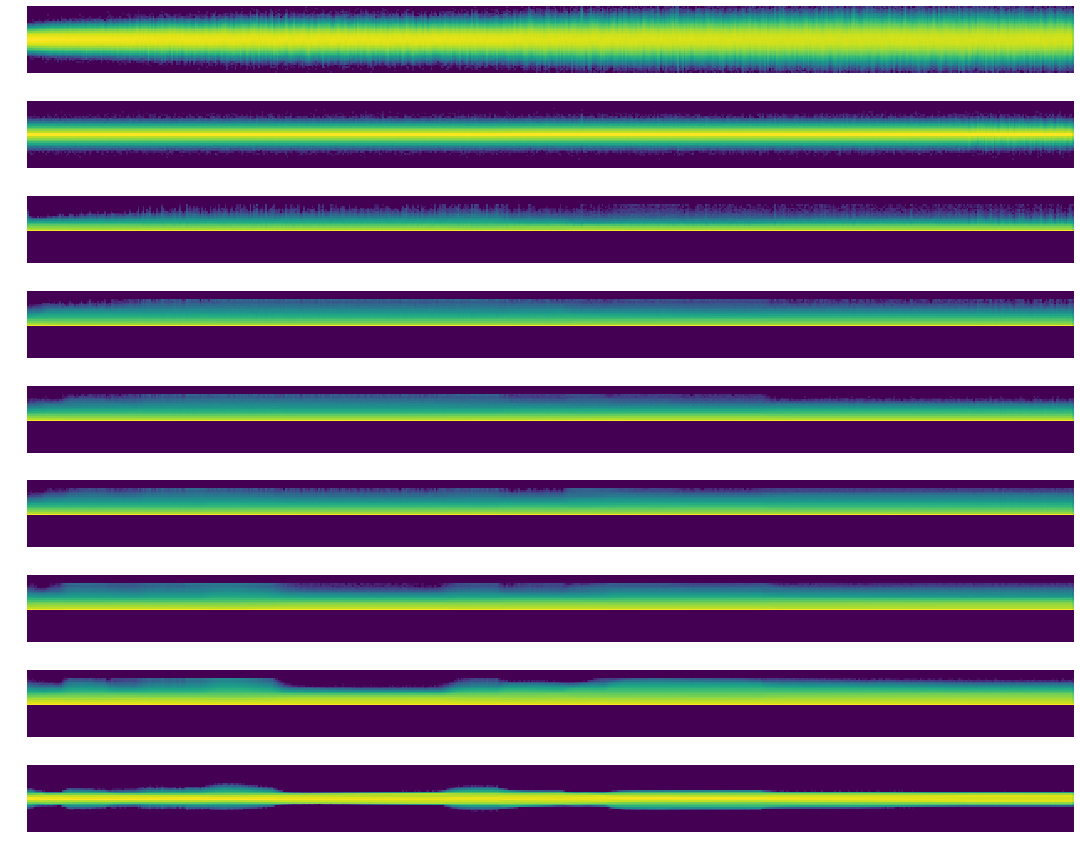

In [72]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

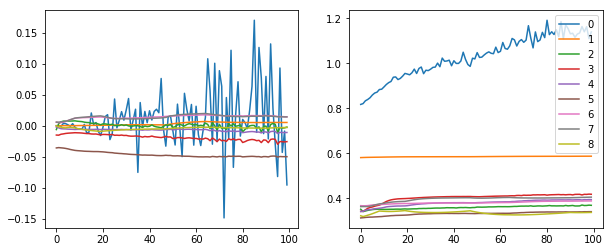

In [75]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

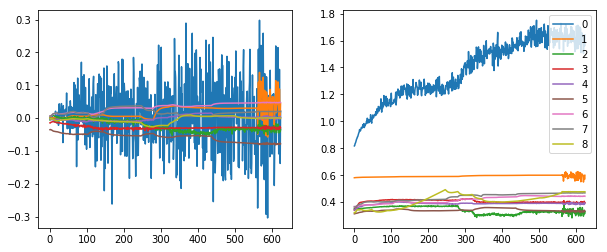

In [76]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

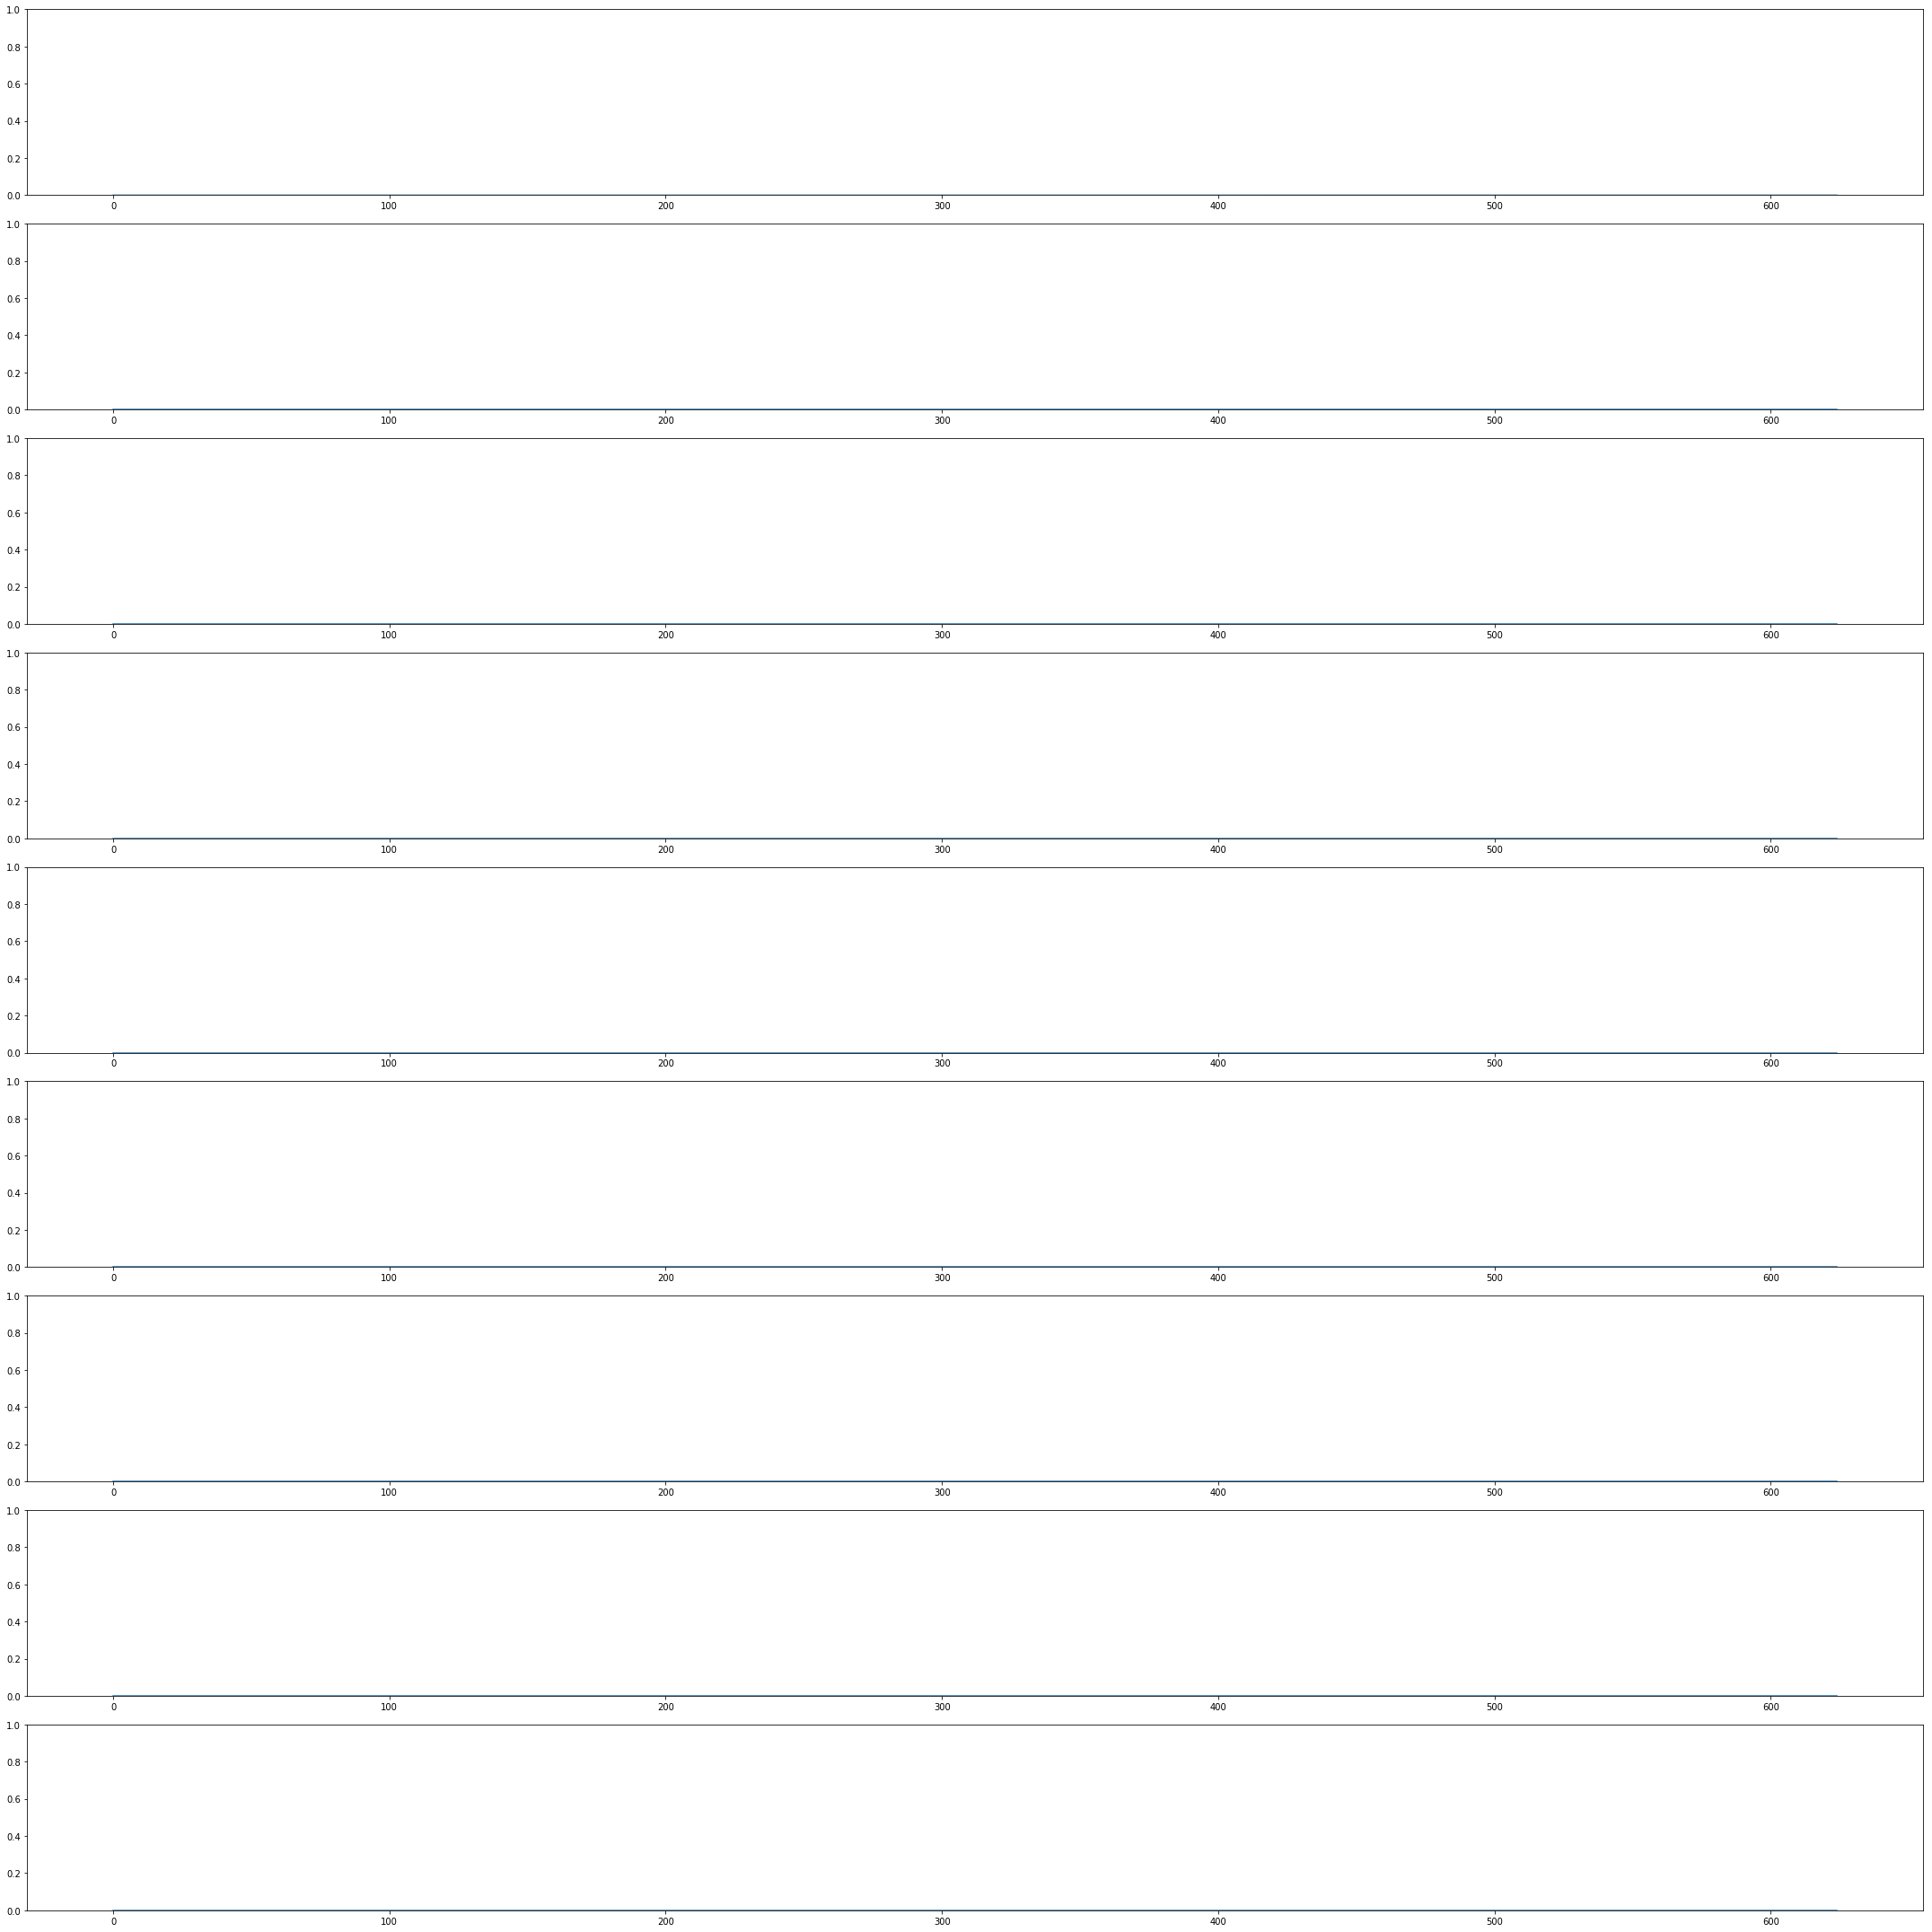

In [77]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [20]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, percentage):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(200)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [21]:
#on validation
%precision 2
n, hist = targeted_diversity(learn, 95)
n, hist
# n, hist, tk = diversity(learn, 10, 95)
# n, hist, tk

at batch_no 0
at batch_no 100
at batch_no 200
at batch_no 300
at batch_no 400
at batch_no 500
at batch_no 600
at batch_no 700
at batch_no 800
at batch_no 900
at batch_no 1000
at batch_no 1100
at batch_no 1200
at batch_no 1300
at batch_no 1400
at batch_no 1500
at batch_no 1600
at batch_no 1700
at batch_no 1800
at batch_no 1900
at batch_no 2000
at batch_no 2100
at batch_no 2200
at batch_no 2300
at batch_no 2400
at batch_no 2500
at batch_no 2600
at batch_no 2700
at batch_no 2800
at batch_no 2900
at batch_no 3000
at batch_no 3100
at batch_no 3200
at batch_no 3300
at batch_no 3400
at batch_no 3500
at batch_no 3600
at batch_no 3700
at batch_no 3800
at batch_no 3900
at batch_no 4000
at batch_no 4100
at batch_no 4200
at batch_no 4300
at batch_no 4400
at batch_no 4500
at batch_no 4600
at batch_no 4700
at batch_no 4800
at batch_no 4900
at batch_no 5000
at batch_no 5100
at batch_no 5200
at batch_no 5300
at batch_no 5400
at batch_no 5500
at batch_no 5600
at batch_no 5700
at batch_no 5800
at batch_

(908,
 [(743, 144.00),
  (834, 126.00),
  (652, 110.00),
  (674, 110.00),
  (848, 102.00),
  (483, 98.00),
  (489, 98.00),
  (611, 96.00),
  (162, 94.00),
  (497, 93.00),
  (785, 93.00),
  (598, 92.00),
  (208, 86.00),
  (424, 86.00),
  (491, 86.00),
  (646, 85.00),
  (549, 84.00),
  (877, 84.00),
  (921, 84.00),
  (679, 83.00),
  (791, 82.00),
  (839, 82.00),
  (851, 81.00),
  (425, 80.00),
  (831, 80.00),
  (700, 79.00),
  (819, 79.00),
  (909, 79.00),
  (58, 78.00),
  (234, 78.00),
  (713, 78.00),
  (256, 77.00),
  (281, 77.00),
  (480, 77.00),
  (527, 77.00),
  (833, 77.00),
  (103, 76.00),
  (343, 76.00),
  (884, 76.00),
  (382, 75.00),
  (579, 75.00),
  (614, 75.00),
  (895, 75.00),
  (82, 74.00),
  (222, 74.00),
  (349, 74.00),
  (847, 74.00),
  (3, 73.00),
  (174, 73.00),
  (265, 73.00),
  (313, 73.00),
  (471, 73.00),
  (630, 73.00),
  (904, 73.00),
  (197, 72.00),
  (366, 72.00),
  (419, 72.00),
  (458, 72.00),
  (523, 72.00),
  (203, 71.00),
  (237, 71.00),
  (245, 71.00),
 

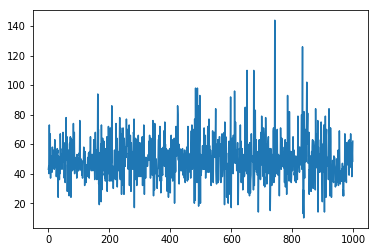

In [22]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [23]:
entropy(values)

tensor(9.9102)

In [24]:
distance_from_uniform(values)

tensor(0.8846)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [482]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result
  
def big_vector_to_str(x, thresh = 0.01):
  torch.set_printoptions(precision=2, sci_mode=False, threshold=5000)  
  result = "["
  for i, x_i in enumerate(x.data):
    if abs(x_i) > thresh:
      result += "{}: {:.2f}".format(i, x_i.item()) 
      result += ", " if (i < x.shape[0]-1) else ""
  result += "]"
  return result

def print_big_vector(x, thresh = 0.01):
  print(big_vector_to_str(x, thresh))

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [484]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [127]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [153]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [157]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)